In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [5]:
df = pd.read_csv("data/data.txt",header=None,sep=" ").sort_values(by=[0,1]).reset_index(drop=True)
df.columns = ["date",'time','epoch','moteid','temperature','humidity','light','voltage']
df['timestamp'] = pd.to_datetime(df['date'] +' '+ df['time'])

# EDA

## Missing value imputation

In [7]:
df.isna().any()

date           False
time           False
epoch          False
moteid          True
temperature     True
humidity        True
light           True
voltage         True
timestamp      False
dtype: bool

### moteid

As per the data file, moteid range from 1-54, hence removing other data values

In [8]:
unknown_sensor_ids = list(df[df['moteid'] > 54]['moteid'].unique())

In [9]:
df_removed_unknowns = df[~df['moteid'].isin(unknown_sensor_ids)]

In [8]:
df_removed_unknowns['moteid'].isna().any()

True

moteid is the sensorId and having a NAN values in the sensorId is invalid, hence checking the sensor values like temperature, voltage, light, humidity for sensorId with NAN values.

In [10]:
df_testing = df_removed_unknowns[df_removed_unknowns['moteid'].isnull()==True]

In [11]:
df_testing[((df_testing['temperature'].isnull()==False) | (df_testing['humidity'].isnull()==False) |\
           (df_testing['light'].isnull()==False) | (df_testing['voltage'].isnull()==False))]

,date,time,epoch,moteid,temperature,humidity,light,voltage,timestamp


Sensor values like temperature,voltage,light,humidity is NAN when sensorid is NAN, hence removing the values where moteid(sensorid) is NAN

In [12]:
df_removed_nan = df_removed_unknowns[df_removed_unknowns['moteid'].isnull()==False]

 Changing the type of moteid as per input file

In [13]:
df_with_full_moteid = df_removed_nan.astype({"moteid": int})

In [14]:
df_with_full_moteid.isna().any()

date           False
time           False
epoch          False
moteid         False
temperature     True
humidity        True
light           True
voltage        False
timestamp      False
dtype: bool

### Now, Imputing the values for sensor values like temperature, humidity and light which has null values using interpolate method

In [15]:
df_with_full_moteid['temperature']= df_with_full_moteid['temperature'].interpolate(method='linear')
df_with_full_moteid['humidity']= df_with_full_moteid['humidity'].interpolate(method='linear')
df_with_full_moteid['light']= df_with_full_moteid['light'].interpolate(method='linear')

In [16]:
df_new = df_with_full_moteid
df_new.isna().any()

date           False
time           False
epoch          False
moteid         False
temperature    False
humidity       False
light          False
voltage        False
timestamp      False
dtype: bool

In [17]:
df_new.sample(5)

,date,time,epoch,moteid,temperature,humidity,light,voltage,timestamp
205493,2004-03-01,06:26:33.169436,6417,18,16.5976,48.1893,2.76,2.45421,2004-03-01 06:26:33.169436
1502007,2004-03-17,05:09:19.417773,52342,53,21.1742,33.9442,0.46,2.46440,2004-03-17 05:09:19.417773
1311250,2004-03-14,01:50:41.712295,43305,13,19.5964,46.3937,1.15,2.46440,2004-03-14 01:50:41.712295
1932520,2004-03-23,09:34:37.628691,33677,38,122.1530,43.6188,426.88,2.29313,2004-03-23 09:34:37.628691
663806,2004-03-06,06:18:05.394353,20800,2,19.5180,43.5855,128.80,2.58226,2004-03-06 06:18:05.394353


## Understanding the correlation between the sensor values

In [18]:
df_numeric = df_new.select_dtypes(include = ['float'])

plotting the heatmap to find correlation

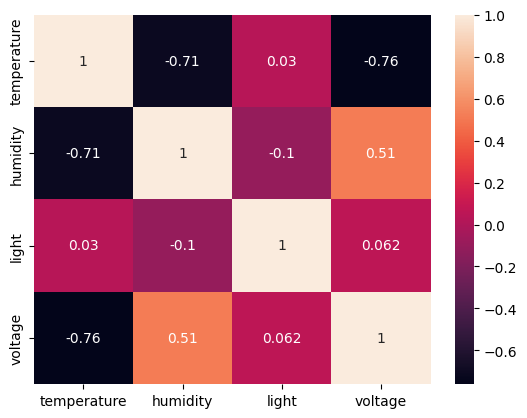

In [19]:
sns.heatmap(df_numeric.corr(), annot=True);

Based on this plot, temperature is inversely correlated with voltage and humidity, so we can infer that hotter and drier environments correlate to more energy efficient ones.

/var/folders/65/w_x1mqn91cjgf0z9wdr_5mt40000gn/T/ipykernel_31634/3130923011.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rollmean = df_wide.resample(rule='D',on='timestamp').mean().reset_index()
/var/folders/65/w_x1mqn91cjgf0z9wdr_5mt40000gn/T/ipykernel_31634/3130923011.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rollstd = df_wide.resample(rule='D',on='timestamp').std().reset_index()


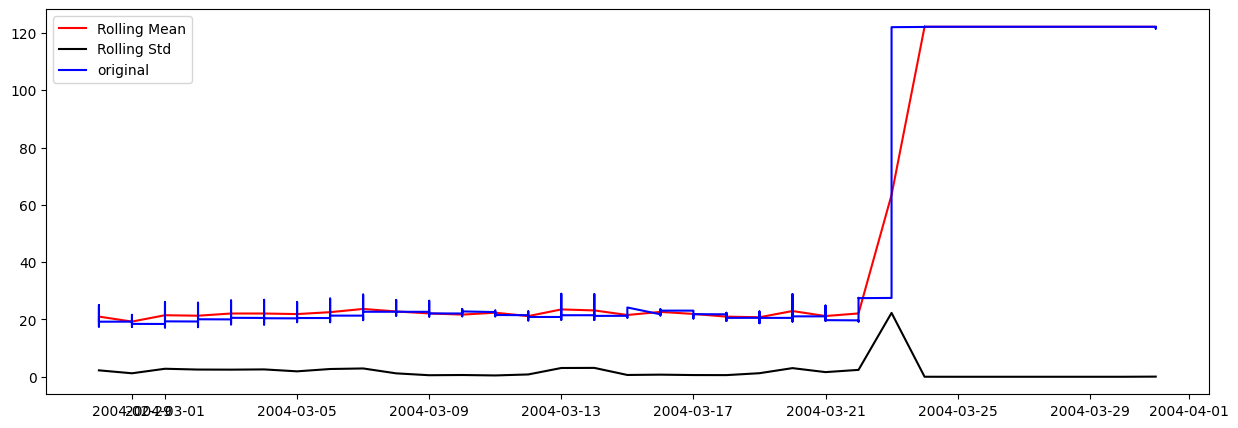

In [20]:
### Checking time series data is stationary or not

df_sensor_1  = df_new[df_new['moteid']==1]

df_wide = df_sensor_1.pivot(index='timestamp',columns='moteid',values='temperature').reset_index()
df_wide['date'] = df_wide['timestamp'].dt.date

rollmean = df_wide.resample(rule='D',on='timestamp').mean().reset_index()
rollstd = df_wide.resample(rule='D',on='timestamp').std().reset_index()

rollstd['timestamp'] = pd.to_datetime(rollstd['timestamp'])
rollmean['timestamp'] = pd.to_datetime(rollmean['timestamp'])

plt.figure(figsize=(15,5))
plt.plot(rollmean['timestamp'],rollmean[1], color='red', label='Rolling Mean')
plt.plot(rollstd['timestamp'],rollstd[1], color='black', label='Rolling Std' )
plt.plot(df_wide['date'],df_wide[1],color='blue',label='original')
plt.legend()
plt.show();

## Scaling the data

From the above correlation it is understood that temperature has higher importance, hence scaling the data to be efficient for machine learning

Since temperature can be bound to outliers, hence using RobustScaler

In [19]:
ct = make_column_transformer(
      (RobustScaler(), ["temperature"]),
      remainder="passthrough"
    )

#apply the transformation and describe the output
xt = ct.fit_transform(df_new)
df_transformed = pd.DataFrame(xt)
df_transformed.columns = ['temperature','date', 'time', 'epoch', 'moteid',  'humidity', 'light',
       'voltage', 'timestamp']

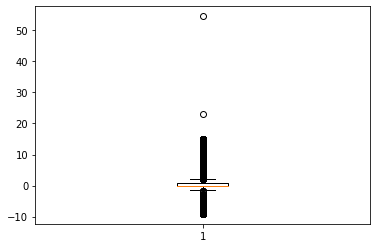

In [20]:
plt.boxplot(np.array(df_transformed['temperature']))
plt.show();